In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

device="cpu"

/home/twhit/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Load results

In [2]:
true_counts = torch.load("../images/true_counts.pt").to(device)[:100]
true_fluors = torch.load("../images/true_fluors.pt").to(device)[:100]
true_locs = torch.load("../images/true_locs.pt").to(device)[:100]
true_axes = torch.load("../images/true_axes.pt").to(device)[:100]
true_angles = torch.load("../images/true_angles.pt").to(device)[:100]
true_total_intensities = torch.load("../images/true_total_intensities.pt").to(device)[:100]
images = torch.load("../images/images.pt").to(device)[:100]
num_images = images.shape[0]
max_objects = true_fluors.shape[1]

posterior_mean_count = torch.load("small_batch_posterior_mean_count.pt").to(device)
posterior_mean_total_fluor = torch.load("small_batch_posterior_mean_total_fluor.pt").to(device)
reconstructed_image = torch.load("small_batch_reconstructed_image.pt").to(device)
runtime = torch.load("small_batch_runtime.pt").to(device)
num_iters = torch.load("small_batch_num_iters.pt").to(device)

### Overall summary

In [3]:
print(f"RMSE (cell count) across {images.shape[0]} images:",
      ((posterior_mean_count - true_counts)**2).mean().sqrt().item())
print(f"MAE (cell count) across {images.shape[0]} images:",
      ((posterior_mean_count - true_counts).abs()).mean().item())
print(f"RMSE (total fluorescence) across {images.shape[0]} images:",
      ((posterior_mean_total_fluor - true_fluors.sum(1))**2).mean().sqrt().item())
print(f"MAE (total fluorescence) across {images.shape[0]} images:",
      ((posterior_mean_total_fluor - true_fluors.sum(1)).abs()).mean().item())
print(f"correct number of cells detected in {(posterior_mean_count.round() == true_counts).sum()} of the {images.shape[0]} images (accuracy = {((posterior_mean_count.round() == true_counts).sum()/images.shape[0])})")
print(f"runtime: minimum = {runtime.min().int()}, mean = {runtime.mean().int()}, median = {runtime.median().int()}, maximum = {runtime.max().int()}")
print(f"number of iterations: minimum = {num_iters.min().int()}, mean = {num_iters.mean().int()}, median = {num_iters.median().int()}, maximum = {num_iters.max().int()}")

RMSE (cell count) across 100 images: 0.09994865953922272
MAE (cell count) across 100 images: 0.01193576492369175
RMSE (total fluorescence) across 100 images: 2.8747165203094482
MAE (total fluorescence) across 100 images: 1.9101814031600952
correct number of cells detected in 99 of the 100 images (accuracy = 0.9900000095367432)
runtime: minimum = 0, mean = 28, median = 29, maximum = 62
number of iterations: minimum = 0, mean = 13, median = 14, maximum = 29


In [4]:
mean_posterior_mean_count_by_count = torch.zeros(max_objects+1)
bounds_posterior_mean_count_by_count = torch.zeros(max_objects+1, 2)
num_correct_by_count = torch.zeros(max_objects+1)
prop_correct_by_count = torch.zeros(max_objects+1)
rmse_by_count = torch.zeros(max_objects+1)
mae_by_count = torch.zeros(max_objects+1)
bounds_mae_by_count = torch.zeros(max_objects+1, 2)
rmse_total_fluor_by_count = torch.zeros(max_objects+1)
mae_total_fluor_by_count = torch.zeros(max_objects+1)

for num in range(max_objects+1):
    print(f"true count = {num}")
    
    mean_posterior_mean_count_by_count[num] = posterior_mean_count[true_counts==num].mean()
    print(f"estimated count for images where s = {num}:", mean_posterior_mean_count_by_count[num].item())
    bounds_posterior_mean_count_by_count[num] = posterior_mean_count[true_counts==num].quantile(torch.tensor((0.05, 0.95)))
    
    rmse_by_count[num] = ((posterior_mean_count[true_counts==num] - true_counts[true_counts==num])**2).mean().sqrt()
    print(f"RMSE (count) across {(true_counts==num).sum()} images:", (rmse_by_count[num].item()))
    
    mae_by_count[num] = ((posterior_mean_count[true_counts==num] - true_counts[true_counts==num]).abs()).mean()
    print(f"MAE (count) across {(true_counts==num).sum()} images:", (mae_by_count[num].item()))
    bounds_mae_by_count[num] = ((posterior_mean_count[true_counts==num] - true_counts[true_counts==num]).abs()).quantile(torch.tensor((0.05, 0.95)))
    
    rmse_total_fluor_by_count[num] = ((posterior_mean_total_fluor[true_counts==num] - true_fluors[true_counts==num].sum(1))**2).mean().sqrt()
    print(f"RMSE (total fluor) across {(true_counts==num).sum()} images:", (rmse_total_fluor_by_count[num].item()))
    
    mae_total_fluor_by_count[num] = ((posterior_mean_total_fluor[true_counts==num] - true_fluors[true_counts==num].sum(1)).abs()).mean()
    print(f"MAE (total fluor) across {(true_counts==num).sum()} images:", (mae_total_fluor_by_count[num].item()))
    
    num_correct_by_count[num] = (posterior_mean_count[true_counts==num].round() == true_counts[true_counts==num]).sum()
    prop_correct_by_count[num] = num_correct_by_count[num]/(true_counts==num).sum()
    print(f"correct count in {num_correct_by_count[num].int()} of the {(true_counts==num).sum()} images (accuracy = {prop_correct_by_count[num]})")
    
    print(f"runtime: minimum = {runtime[true_counts==num].min().int()}, median = {runtime[true_counts==num].median().int()}, maximum = {runtime[true_counts==num].max().int()}")
    print(f"number of iterations: minimum = {num_iters[true_counts==num].min().int()}, median = {num_iters[true_counts==num].median().int()}, maximum = {num_iters[true_counts==num].max().int()}\n")

true count = 0
estimated count for images where s = 0: 0.0
RMSE (count) across 17 images: 0.0
MAE (count) across 17 images: 0.0
RMSE (total fluor) across 17 images: 0.0
MAE (total fluor) across 17 images: 0.0
correct count in 17 of the 17 images (accuracy = 1.0)
runtime: minimum = 0, median = 0, maximum = 0
number of iterations: minimum = 0, median = 0, maximum = 0

true count = 1
estimated count for images where s = 1: 1.0000587701797485
RMSE (count) across 20 images: 0.00023409568530041724
MAE (count) across 20 images: 5.882382538402453e-05
RMSE (total fluor) across 20 images: 1.2304834127426147
MAE (total fluor) across 20 images: 0.9699974060058594
correct count in 20 of the 20 images (accuracy = 1.0)
runtime: minimum = 19, median = 21, maximum = 25
number of iterations: minimum = 9, median = 10, maximum = 12

true count = 2
estimated count for images where s = 2: 2.0087456703186035
RMSE (count) across 21 images: 0.029896631836891174
MAE (count) across 21 images: 0.00874543190002441

### Figure 2: Reconstructed images

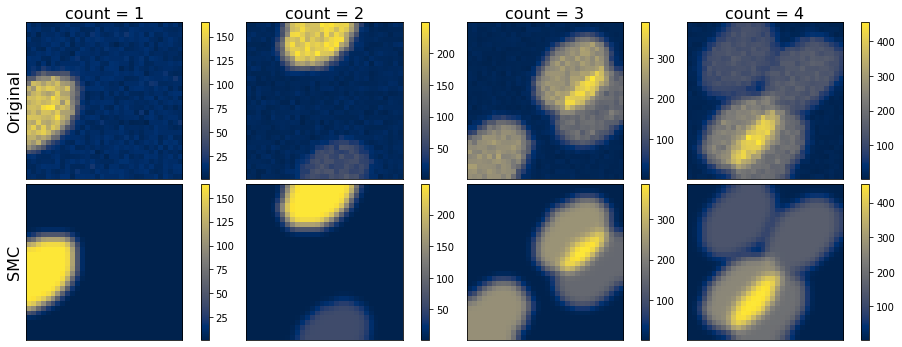

In [5]:
torch.manual_seed(1)

fontsize = 16
cmap = 'cividis'

example_image_indexes = [torch.arange(num_images)[true_counts==1][torch.randint(low=0, high=(true_counts==1).sum(), size=(1,))].item(),
                         torch.arange(num_images)[true_counts==2][torch.randint(low=0, high=(true_counts==2).sum(), size=(1,))].item(),
                         torch.arange(num_images)[true_counts==3][torch.randint(low=0, high=(true_counts==3).sum(), size=(1,))].item(),
                         torch.arange(num_images)[true_counts==4][torch.randint(low=0, high=(true_counts==4).sum(), size=(1,))].item()]
fig2_counts = true_counts[example_image_indexes]
fig2_original = images[example_image_indexes]
fig2_smc = reconstructed_image[example_image_indexes]

fig2, ax = plt.subplots(nrows = 2, ncols = 4, sharex = True, sharey = True, figsize = (15,5))
fig2.tight_layout(h_pad = -0.5, w_pad = -0.5)

for i in range(len(example_image_indexes)):
    f2_orig = ax[0,i].imshow(fig2_original[i].cpu(), cmap = cmap)
    _ = ax[0,i].set_xlabel(f"count = {fig2_counts[i].int()}", fontsize = fontsize)
    _ = ax[0,i].xaxis.set_label_position("top")
    _ = ax[0,i].set_xticks([])
    _ = ax[0,i].set_yticks([])
    plt.colorbar(f2_orig, ax = ax[0,i])

    f2_smc = ax[1,i].imshow(fig2_smc[i].cpu(), cmap = cmap)
    _ = ax[1,i].set_xticks([])
    _ = ax[1,i].set_yticks([])
    plt.colorbar(f2_orig, ax = ax[1,i])

_ = ax[0,0].set_ylabel("Original", loc = "center", fontsize = fontsize)
_ = ax[1,0].set_ylabel("SMC", loc = "center", fontsize = fontsize)

fig2.subplots_adjust(wspace=-0.4)
# fig2.savefig('results/fig2.png', dpi=500)

### Figure 3: Calibration and absolute error

In [6]:
# Bootstrap CIs for classification accuracy
torch.manual_seed(0)

num_boot_samples = 10000
bounds_prop_correct_by_count = torch.zeros(max_objects+1, 2)

for num in range(max_objects+1):
    boot_orig = torch.stack((posterior_mean_count[true_counts==num].round(), true_counts[true_counts==num]), dim = 1)
    boot_prop_correct = torch.zeros(num_boot_samples)
    
    for j in range(num_boot_samples):
        boot_sample = boot_orig[(torch.multinomial(torch.arange(boot_orig.size(0)).double(), num_samples = boot_orig.size(0), replacement = True))]
        boot_prop_correct[j] = (boot_sample[:,0] == boot_sample[:,1]).sum()/boot_orig.size(0)
    
    bounds_prop_correct_by_count[num] = boot_prop_correct.quantile(torch.tensor((0.05, 0.95),device=device))

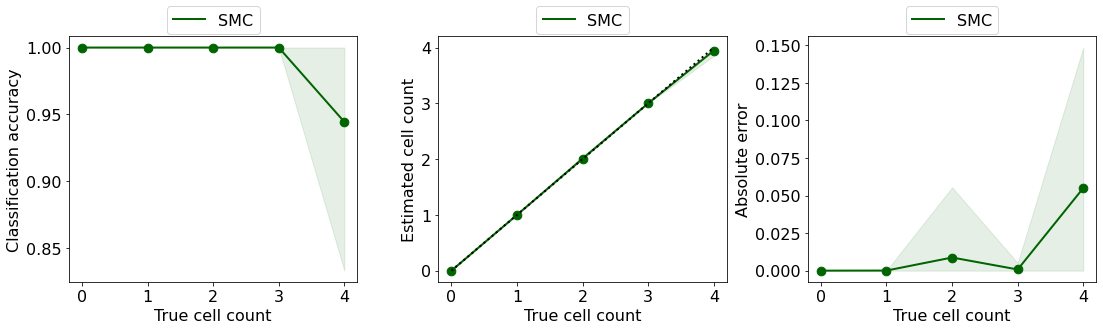

In [8]:
dot_size = 75
line_width = 2
text_size = 16
color = "darkgreen"

range_max_objects = torch.arange(max_objects+1, device="cpu")

fig3, (fig3a,fig3b,fig3c) = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4))
fig3.tight_layout(w_pad = 5)

_ = fig3a.plot(range_max_objects, prop_correct_by_count.cpu(), label = "SMC", color = color, linewidth = line_width)
_ = fig3a.scatter(range_max_objects, prop_correct_by_count.cpu(), color = color, s = dot_size)
_ = fig3a.fill_between(range_max_objects, bounds_prop_correct_by_count[:,0].cpu(), bounds_prop_correct_by_count[:,1].cpu(), color = color, alpha = 0.1)
_ = fig3a.legend(ncol=2, fancybox=True, loc="upper center", bbox_to_anchor=(0.5,1.155), fontsize = text_size)
_ = fig3a.tick_params(axis = "both", labelsize = text_size)
_ = fig3a.set_xlabel("True cell count", fontsize = text_size)
_ = fig3a.set_ylabel("Classification accuracy", fontsize = text_size)

_ = fig3b.plot(range_max_objects, mean_posterior_mean_count_by_count.cpu(), color = color, label = "SMC", linewidth = line_width)
_ = fig3b.scatter(range_max_objects, mean_posterior_mean_count_by_count.cpu(), color = color, s = dot_size)
_ = fig3b.fill_between(range_max_objects, bounds_posterior_mean_count_by_count[:,0].cpu(), bounds_posterior_mean_count_by_count[:,1].cpu(), color = color, alpha = 0.1)
_ = fig3b.plot(range_max_objects, range_max_objects, ":", color="black", linewidth = line_width)
_ = fig3b.legend(ncol=2, fancybox=True, loc="upper center", bbox_to_anchor=(0.5,1.155), fontsize = text_size)
_ = fig3b.tick_params(axis = "both", labelsize = text_size)
_ = fig3b.set_xlabel("True cell count", fontsize = text_size)
_ = fig3b.set_ylabel("Estimated cell count", fontsize = text_size)

_ = fig3c.plot(range_max_objects, (mae_by_count).cpu(), label = "SMC", color = color, linewidth = line_width)
_ = fig3c.scatter(range_max_objects, mae_by_count.cpu(), color = color, s = dot_size)
_ = fig3c.fill_between(range_max_objects, bounds_mae_by_count[:,0].cpu(), bounds_mae_by_count[:,1].cpu(), color = color, alpha = 0.1)
_ = fig3c.legend(ncol=2, fancybox=True, loc="upper center", bbox_to_anchor=(0.5,1.155), fontsize = text_size)
_ = fig3c.tick_params(axis = "both", labelsize = text_size)
_ = fig3c.set_xlabel("True cell count", fontsize = text_size)
_ = fig3c.set_ylabel("Absolute error", fontsize = text_size)

# fig3.savefig('results/figures/fig3.png', bbox_inches = "tight", dpi = 500)